In [ ]:
# If you use Google Colab, uncomment these lines:
#! wget https://raw.githubusercontent.com/Ayagoz/Tips-Tricks/master/lesson_2/cv.py
#! wget https://raw.githubusercontent.com/Ayagoz/Tips-Tricks/master/lesson_2/requirements.txt
#! pip install -r requirements.txt

In [1]:
import numpy as np

from dpipe.medim.preprocessing import get_greatest_component
from dpipe.medim.box import mask2bounding_box, add_margin, box2slices
from dpipe.medim.utils import apply_along_axes

from dpipe.medim.visualize import slice3d

from skimage.filters import gaussian
from skimage.morphology import binary_opening, disk

from scipy.ndimage import convolve
from scipy.interpolate import UnivariateSpline

from functools import partial
from matplotlib import pyplot as plt

In [2]:
from cv import *

In [3]:
load_patient = lambda i: np.load('./Patient_%0.2d.npy' % i)

In [4]:
x = load_patient(7)[...,::-1].transpose(1,0,2)

In [5]:
x.shape, x.min(), x.max()

((512, 512, 143), -1000.0, 2751.6196)

In [6]:
temp_x = x.transpose(2,0,1)

In [7]:
slice3d(x, scale=10)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=142), Output()), _dom…

In [8]:
slice3d(temp_x, scale=10)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=511), Output()), _dom…

In [9]:
s = (x > 250).sum(axis=(2))
s_ = gaussian(s, sigma=3, preserve_range=True)    
s__ = s_ / s_.max() > 0.45
s___ = binary_opening(s__, disk(4))

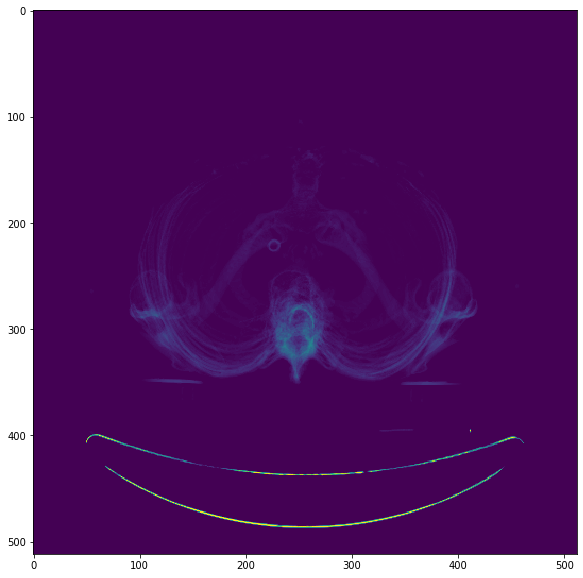

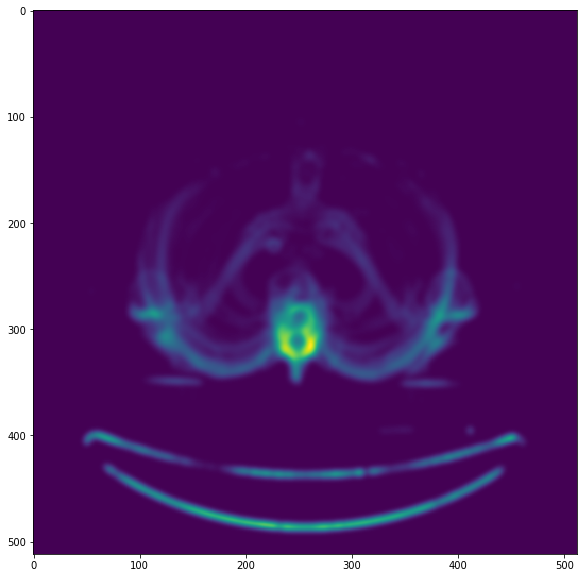

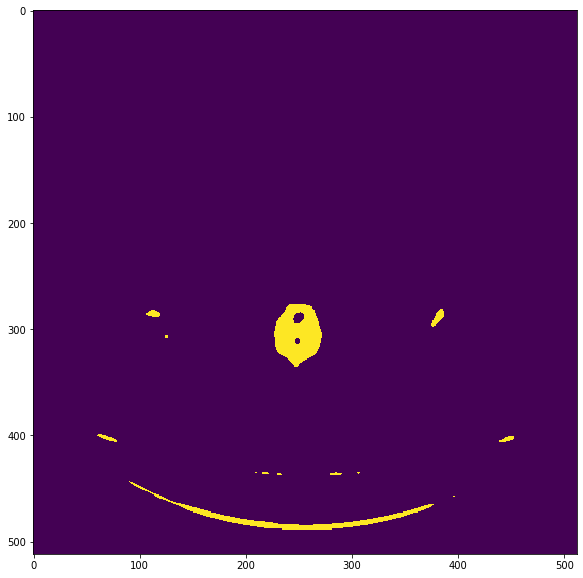

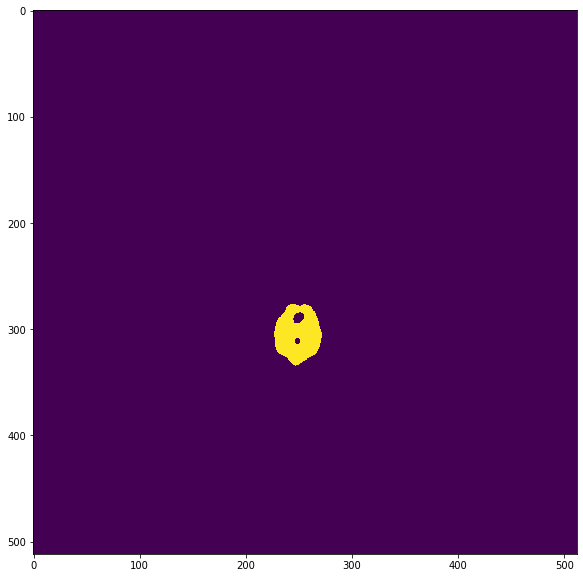

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(s)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(s_)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(s__)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(s___)
plt.show()

In [11]:
# Найдем позвоночник

In [12]:
y = cut_spine(x)

In [13]:
slice3d(y)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=142), Output()), _dom…

In [14]:
y = y.transpose(2, 0, 1)

In [15]:
slice3d(y)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=44), Output()), _dom_…

In [16]:
y_ = y > 120
b_r = 3
b_h = 50
#цилиндр высоты b_h и радиуса b_r
bone_cylinder = np.stack([disk(b_r) for i in range(b_h)])
y__ = convolve(y_.astype(float), bone_cylinder) / bone_cylinder.sum()
y_b = get_greatest_component(y__ > 0.15)

In [17]:
slice3d(y_, y__, y_b, axis=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=142), Output()), _dom…

In [18]:
slice3d(y_, y__, y_b)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=44), Output()), _dom_…

In [19]:
y_spine = get_mask_full_spine(y)
# зальем "по y"
y_ = apply_along_axes(fill_line, y_spine, axes=(1, 2)).astype(bool)
# возьмем неплотное внутри
y_n = (y < 100) & y_
# свернем с цилиндром 
mask = np.stack([disk(7) for i in range(15)])
y__ = convolve(y_n.astype(int), mask) / mask.sum()
y_f = get_greatest_component(y__ > 0.68)

In [100]:
temp_x = cut_spine(x).transpose(2,0,1) + 300*y_f

In [101]:
slice3d(temp_x)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=45), Output()), _dom_…

In [102]:
m = np.zeros(temp_x.transpose(1,2,0).shape).astype(bool)
delta = 1
for i,(a,b) in enumerate(find_centres(y_f)):
    if not np.isnan(a):
        a,b = int(a), int(b)
        m[a-delta:a+delta, b-delta:b+delta, i] = True

In [103]:
t_x = temp_x + 300*m.transpose(2,0,1)

In [104]:
slice3d(t_x, axis=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=245), Output()), _dom…

In [105]:
slice3d(t_x)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=45), Output()), _dom_…